## The problem and data

##### The level of clothing a person is wearing at office is one of the key factors influencing their level of comfort. This assignment aims to model clothing insulation based on:
1. Indoor operating temperature and outdoor temperature (clothingSum.csv).
2. Indoor operating temperature, outdoor temperature and subject ID (clothingSum.csv).
3. Indoor operating temperature, outdoor temperature, subject ID and observation number (clothingFull.csv).

## Problem 1: General linear model

##### Reading the data

In [4]:
setwd("~/Desktop/DTU/Advanced\ Dataanalysis\ and\ Statistical\ Modelling/Assignments")
HE <- read.table("clothingSum.csv", sep=",", header=TRUE, as.is=TRUE)

#### Define all needed libraries

In [45]:
library(ggplot2); suppressWarnings(suppressMessages(library("ggplot2")))
library(MASS); suppressWarnings(suppressMessages(library("MASS")))
library(dplyr); suppressWarnings(suppressMessages(library("dplyr")))
library(corrplot); suppressWarnings(suppressMessages(library("corrplot")))
library(mgcv); suppressWarnings(suppressMessages(library("mgcv")))
library(lmerTest); suppressWarnings(suppressMessages(library("lmerTest")))
library(repr); suppressWarnings(suppressMessages(library("lmerTest")))
library(car); suppressWarnings(suppressMessages(library("car")))

#### Adjust the size of all plots to 5 x 5

In [7]:
options(repr.plot.width=5, repr.plot.height=5)

#### Summary of data

In [8]:
head(HE)

subjId,day,clo,tOut,tInOp,sex
11,1,0.71,20.48765,25.44297,female
17,1,0.65,16.55730,23.16285,female
19,1,0.87,14.54109,24.55617,female
29,1,0.56,20.21969,27.01763,female
35,1,0.34,25.25117,28.61374,male
43,1,0.79,25.22943,27.07381,female


In [9]:
str(HE)

'data.frame':	136 obs. of  6 variables:
 $ subjId: int  11 17 19 29 35 43 47 49 51 55 ...
 $ day   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ clo   : num  0.71 0.65 0.87 0.56 0.34 ...
 $ tOut  : num  20.5 16.6 14.5 20.2 25.3 ...
 $ tInOp : num  25.4 23.2 24.6 27 28.6 ...
 $ sex   : chr  "female" "female" "female" "female" ...


In [10]:
summary(HE)

     subjId           day             clo              tOut      
 Min.   : 11.0   Min.   :1.000   Min.   :0.2467   Min.   :11.93  
 1st Qu.: 59.0   1st Qu.:1.000   1st Qu.:0.4700   1st Qu.:18.57  
 Median : 99.0   Median :2.000   Median :0.5483   Median :21.01  
 Mean   :101.1   Mean   :1.978   Mean   :0.5511   Mean   :21.54  
 3rd Qu.:141.0   3rd Qu.:3.000   3rd Qu.:0.6412   3rd Qu.:24.25  
 Max.   :199.0   Max.   :4.000   Max.   :0.9600   Max.   :33.08  
     tInOp           sex           
 Min.   :23.11   Length:136        
 1st Qu.:26.01   Class :character  
 Median :26.94   Mode  :character  
 Mean   :26.82                     
 3rd Qu.:27.48                     
 Max.   :29.55                     

#### Exclude a subset of attributes

In [11]:
myvars <- names(HE) %in% c("sex", "subjId", "day")
HE_subset <- HE[!myvars]

### Correlation plots

[1] "clo"   "tOut"  "tInOp"

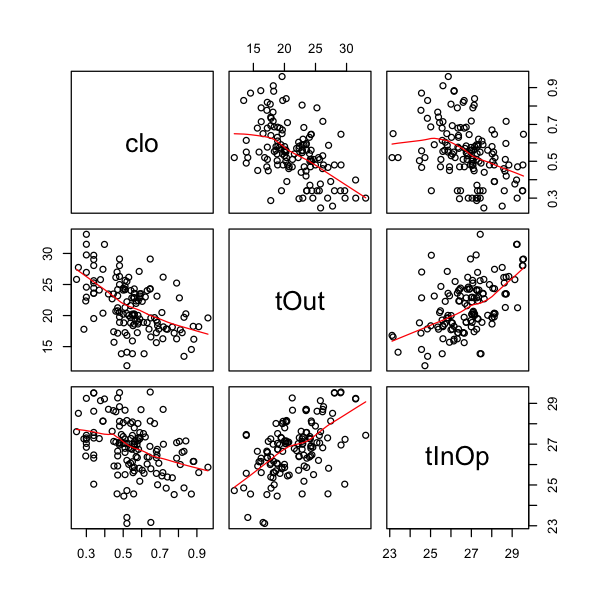

In [12]:
names(HE_subset)
attach(HE_subset)
pairs(HE_subset,panel=panel.smooth)

1. Level of clothing decreases if the outdoor temperature increases (i.e people tend to wear lighter cloths in warmer days).
2. Level of clothing decreases if the outdoor temperature increases. However, the effect is less significant that in the outdoor temperature case.
3. An increase in the outdoor temperature determines and increase in the indoor temperature.

#### Covariance matrix for the level of clothing, outdoor temperature and indoor temperature

In [13]:
cov(HE_subset)

,clo,tOut,tInOp
clo,0.02295290,-0.3220363,-0.07552588
tOut,-0.32203627,17.2760368,2.79966891
tInOp,-0.07552588,2.7996689,1.69431442


#### Correlation matrix for the level of clothing, outdoor temperature and indoor temperature

In [14]:
cor(HE_subset)

,clo,tOut,tInOp
clo,1.0000000,-0.5114038,-0.3829834
tOut,-0.5114038,1.0000000,0.5174729
tInOp,-0.3829834,0.5174729,1.0000000


### Gam plot to get an idea of relationships

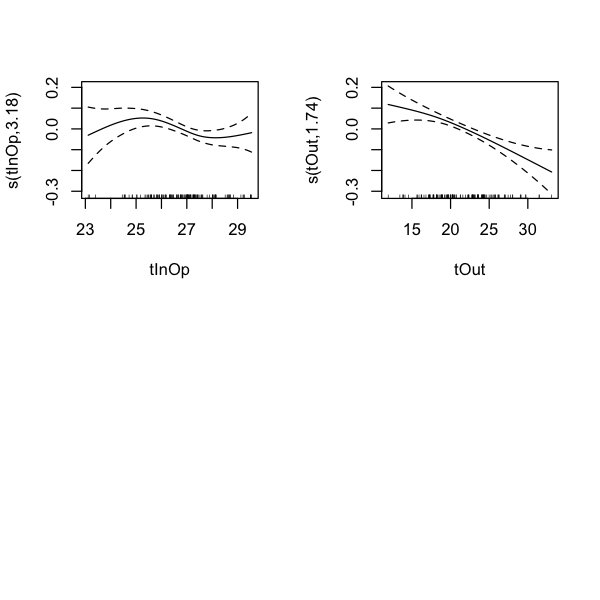

In [13]:
par(mfrow=c(2,2))
model<-gam(clo ~ s(tInOp) + s(tOut),data=HE_subset)
plot(model)

### Histogram for the temperature

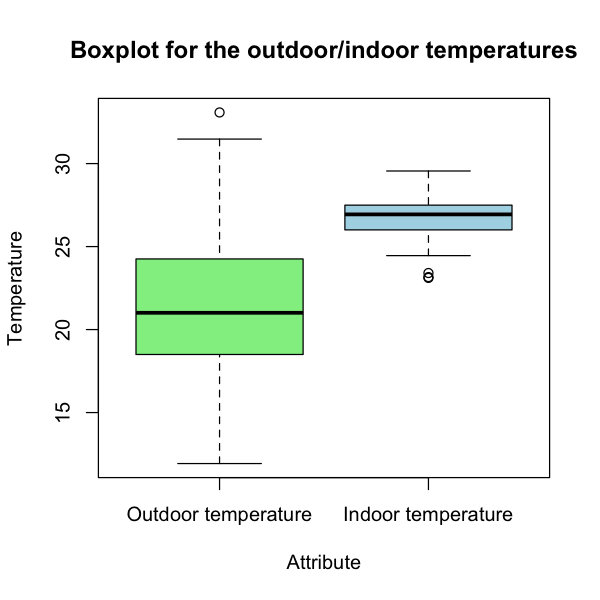

In [14]:
boxplot(HE$tOut, HE$tInOp,
        names=c("Outdoor temperature", "Indoor temperature"), 
        xlab="Attribute", ylab="Temperature", main="Boxplot for the outdoor/indoor temperatures", col=c("lightgreen","Lightblue"))

1. Outdoor temperature is more spread compared to the indoor temperature.
2. Outdoor temperature's mean is 21.54 with an IQR = Q3-Q1 = 24.25-18.57 = 5.68.
3. Indoor temperature's mean is 26.82 with an IQR = Q3-Q1 = 27.48-26.01 = 1.47.

Considering both sexes for level of clothing based on outdoor/indoor temperatures:
1. The level of clothing decreases when the outdoor / indoor temperature increases.
2. A few datapoints fall witin the confidence interval of the simple regression line.
3. Our dataset has a few outliers that do not meet even the prediction interval of the simple regression line.

### Fit general linear model to the data (i.e find the best model by incremental reduction)

#### Initiate the model with some possibly significant variables


Call:
lm(formula = clo ~ sex * tOut * tInOp + I((tInOp - mean(I(tInOp)))^2) + 
    I((tOut - mean(I(tOut)))^2), data = HE)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.32526 -0.05233  0.00484  0.04728  0.30105 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)   
(Intercept)                    6.7973872  2.0783109   3.271  0.00138 **
sexmale                       -5.1269781  2.0533585  -2.497  0.01382 * 
tOut                          -0.2422223  0.0968907  -2.500  0.01371 * 
tInOp                         -0.2177495  0.0773724  -2.814  0.00567 **
I((tInOp - mean(I(tInOp)))^2) -0.0077002  0.0063222  -1.218  0.22551   
I((tOut - mean(I(tOut)))^2)   -0.0014177  0.0005865  -2.417  0.01707 * 
sexmale:tOut                   0.2098350  0.0960544   2.185  0.03077 * 
sexmale:tInOp                  0.1822961  0.0774553   2.354  0.02014 * 
tOut:tInOp                     0.0084150  0.0035811   2.350  0.02034 * 
sexmale:tOut:tInOp            -0.0075

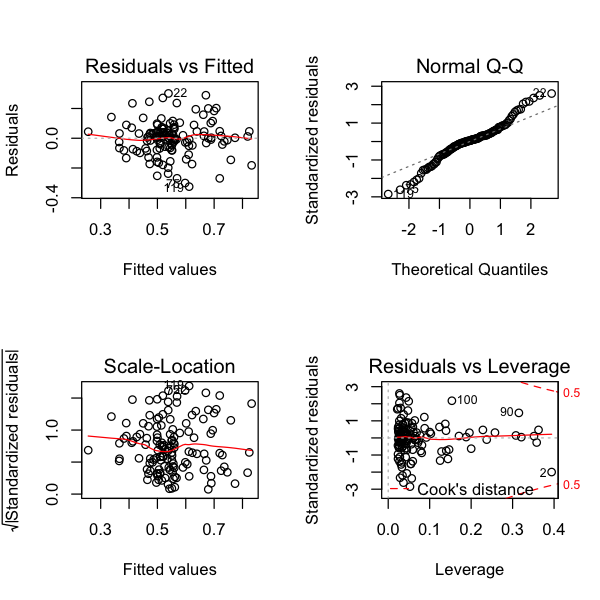

In [17]:
model_1<-lm(clo ~ sex*tOut*tInOp
                + I((tInOp - mean(I(tInOp)))^2) + I((tOut - mean(I(tOut)))^2), 
           data = HE)
summary(model_1)

par(mfrow=c(2,2))
plot(model_1)

1. Most of the variables show significant effect on the level of clothing.
2. The most significant appears to be the indoor temperature (i.e tInOp), the sex (i.e our example "male") and the normalized outdoor temperature (i.e I((tOut - mean(I(tOut)))^2)).
3. The least significant effect on level of clothing is shown by the normalized indoor temperature (i.e I((tInOp - mean(I(tInOp)))^2)).

#### To reduce the significance of sparse datapoints, we test the model on the logarithmic scale


Call:
lm(formula = log(clo) ~ sex * tOut * tInOp + I((tInOp - mean(I(tInOp)))^2) + 
    I((tOut - mean(I(tOut)))^2), data = HE)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.72531 -0.09690  0.03082  0.10849  0.48764 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)   
(Intercept)                    9.920277   4.074593   2.435  0.01631 * 
sexmale                       -9.140789   4.025673  -2.271  0.02487 * 
tOut                          -0.417332   0.189957  -2.197  0.02985 * 
tInOp                         -0.363729   0.151691  -2.398  0.01796 * 
I((tInOp - mean(I(tInOp)))^2) -0.010186   0.012395  -0.822  0.41276   
I((tOut - mean(I(tOut)))^2)   -0.003079   0.001150  -2.678  0.00839 **
sexmale:tOut                   0.391079   0.188318   2.077  0.03986 * 
sexmale:tInOp                  0.326656   0.151853   2.151  0.03337 * 
tOut:tInOp                     0.014311   0.007021   2.038  0.04360 * 
sexmale:tOut:tInOp            -0.014065   

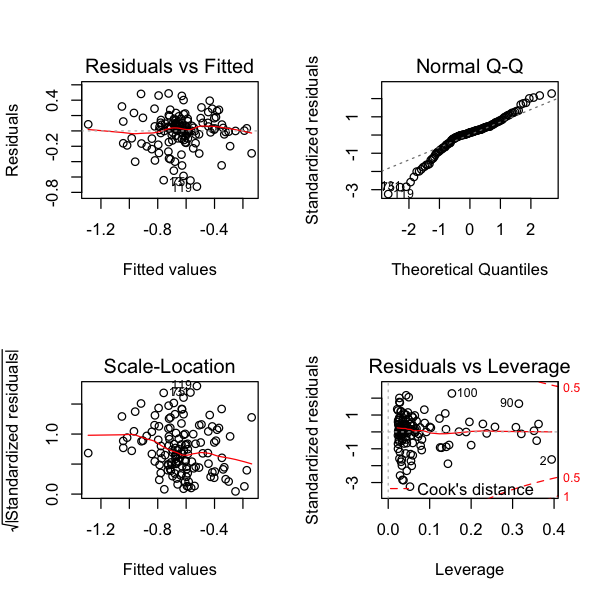

In [18]:
model_2<-lm(log(clo) ~ sex*tOut*tInOp
                + I((tInOp - mean(I(tInOp)))^2) + I((tOut - mean(I(tOut)))^2), 
           data = HE)
summary(model_2)

par(mfrow=c(2,2))
plot(model_2)

A larger significance compared to the linear model is seen from the normalized ourdoor temperature on the level of clothing (i.e I((tOut - mean(I(tOut)))^2))

#### Continue with linear model by reducing incrementally the least significant variables form the model

View which attribute is recommended to be dropped (i.e based on the p-value)

In [19]:
drop1(model_2, test="F")

,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
<none>,NA,NA,6.656269,-390.3250,NA,NA
I((tInOp - mean(I(tInOp)))^2),1,0.03567437,6.691944,-391.5981,0.6752988,0.412762552
I((tOut - mean(I(tOut)))^2),1,0.37885783,7.035127,-384.7965,7.1715979,0.008393945
sex:tOut:tInOp,1,0.21292097,6.869190,-388.0428,4.0304923,0.046824035


In [20]:
model_2a <- update(model_2,~. -I((tInOp - mean(I(tInOp)))^2))
drop1(model_2a, test="F")

,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
<none>,NA,NA,6.691944,-391.5981,NA,NA
I((tOut - mean(I(tOut)))^2),1,0.3537857,7.045729,-386.5917,6.714160,0.01068421
sex:tOut:tInOp,1,0.1905608,6.882504,-389.7794,3.616472,0.05947520


In [21]:
model_2b <- update(model_2a,~. -sex:tOut:tInOp)
drop1(model_2b, test="F")

,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
<none>,NA,NA,6.882504,-389.7794,NA,NA
I((tOut - mean(I(tOut)))^2),1,0.23942581,7.121930,-387.1287,4.4528128,0.03679023
sex:tOut,1,0.05598606,6.938491,-390.6776,1.0412221,0.30946216
sex:tInOp,1,0.05549594,6.938000,-390.6872,1.0321069,0.31158080
tOut:tInOp,1,0.04067172,6.923176,-390.9781,0.7564078,0.38608305


In [22]:
model_2c <- update(model_2b,~. -tOut:tInOp)
drop1(model_2c, test="F")

,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
<none>,NA,NA,6.923176,-390.9781,NA,NA
I((tOut - mean(I(tOut)))^2),1,0.20143181,7.124608,-389.0776,3.7532922,0.05488918
sex:tOut,1,0.04278653,6.965963,-392.1402,0.7972443,0.37358120
sex:tInOp,1,0.06062603,6.983802,-391.7923,1.1296488,0.28983588


In [23]:
model_2d <- update(model_2c,~. -sex:tOut)
drop1(model_2d, test="F")

,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
<none>,NA,NA,6.965963,-392.1402,NA,NA
tOut,1,0.8717163,7.837679,-378.1049,16.268121,9.320252e-05
I((tOut - mean(I(tOut)))^2),1,0.2774197,7.243382,-388.8291,5.177254,2.452107e-02
sex:tInOp,1,0.1675216,7.133484,-390.9083,3.126317,7.938335e-02


,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
<none>,NA,NA,7.133484,-390.9083,NA,NA
sex,1,0.5830792,7.716563,-382.2229,10.707722,1.364160e-03
tOut,1,1.1340148,8.267499,-372.8439,20.825158,1.144299e-05
tInOp,1,0.3101624,7.443647,-387.1200,5.695852,1.843496e-02
I((tOut - mean(I(tOut)))^2),1,0.3411979,7.474682,-386.5541,6.265792,1.353861e-02



Call:
lm(formula = log(clo) ~ sex + tOut + tInOp + I((tOut - mean(I(tOut)))^2), 
    data = HE)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.76617 -0.10623  0.03195  0.12574  0.54524 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  1.2073984  0.4402834   2.742  0.00695 ** 
sexmale                     -0.1336548  0.0408447  -3.272  0.00136 ** 
tOut                        -0.0265305  0.0058137  -4.563 1.14e-05 ***
tInOp                       -0.0435295  0.0182391  -2.387  0.01843 *  
I((tOut - mean(I(tOut)))^2) -0.0022795  0.0009107  -2.503  0.01354 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2334 on 131 degrees of freedom
Multiple R-squared:  0.3662,	Adjusted R-squared:  0.3468 
F-statistic: 18.92 on 4 and 131 DF,  p-value: 2.674e-12


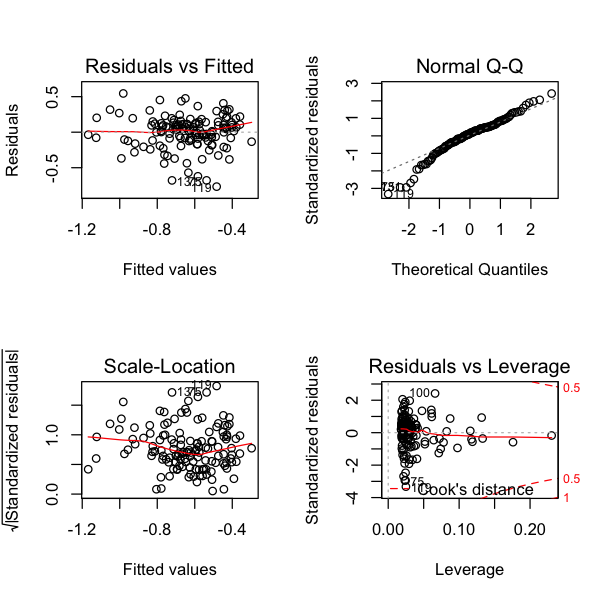

In [33]:
model_2e <- update(model_2d,~. -sex:tInOp)
drop1(model_2e, test="F")

summary(model_2e)
par(mfrow=c(2,2))
plot(model_2e)

Once a significant effect is seen from all the variables in the final model (i.e model_1e), it is fair to conclude that the model reflects the dependancy of level of clothing (i.e clo) as a factor of over variables quite well.

In [50]:
fem <- subset(HE, (sex == 'female'));
male <- subset(HE, (sex == 'male'));

### Simple linear regression for level of clothing (clo) based on outdoor temperature (tOut)

Warning message in predict.lm(fit_tOut, interval = "prediction"):
“predictions on current data refer to _future_ responses
”

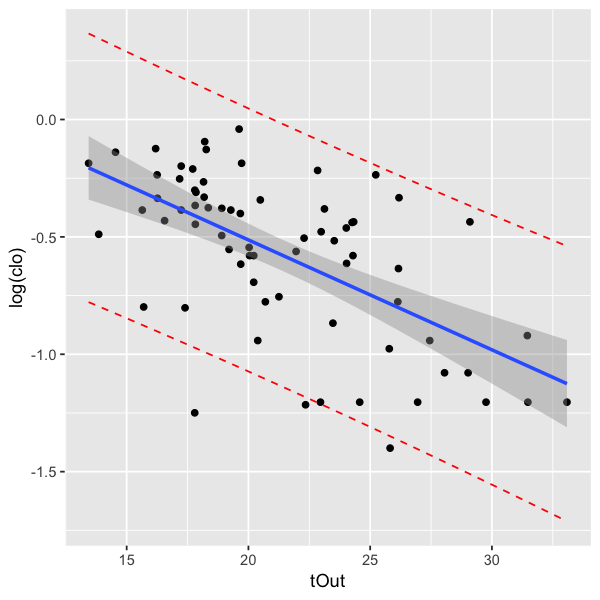

In [59]:
# 1. Add predictions 
fit_tOut <- lm(log(clo) ~ tOut, data = fem)
pred.int <- predict(fit_tOut, interval = "prediction")
mydata <- cbind(fem, pred.int)

# 2. Regression line + confidence intervals
p <- ggplot(mydata, aes(tOut, log(clo))) + geom_point() + stat_smooth(method = lm)

# 3. Add prediction intervals
p + geom_line(aes(y = lwr), color = "red", linetype = "dashed") + geom_line(aes(y = upr), color = "red", linetype = "dashed")

Warning message in predict.lm(fit_tOut, interval = "prediction"):
“predictions on current data refer to _future_ responses
”

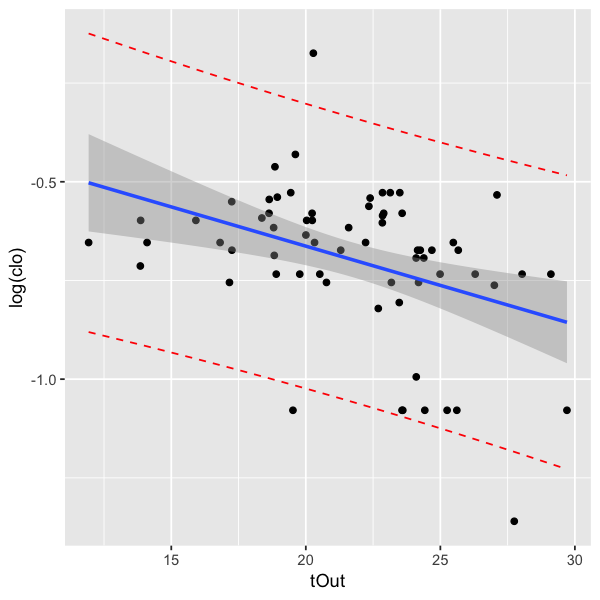

In [52]:
# 1. Add predictions 
fit_tOut <- lm(log(clo) ~ tOut, data = male)
pred.int <- predict(fit_tOut, interval = "prediction")
mydata <- cbind(male, pred.int)

# 2. Regression line + confidence intervals
p <- ggplot(mydata, aes(tOut, log(clo))) + geom_point() + stat_smooth(method = lm)

# 3. Add prediction intervals
p + geom_line(aes(y = lwr), color = "red", linetype = "dashed") + geom_line(aes(y = upr), color = "red", linetype = "dashed")

### Simple linear regression for level of clothing (clo) based on indoor temperature (tInOp)

Warning message in predict.lm(fit_tInOp, interval = "prediction"):
“predictions on current data refer to _future_ responses
”

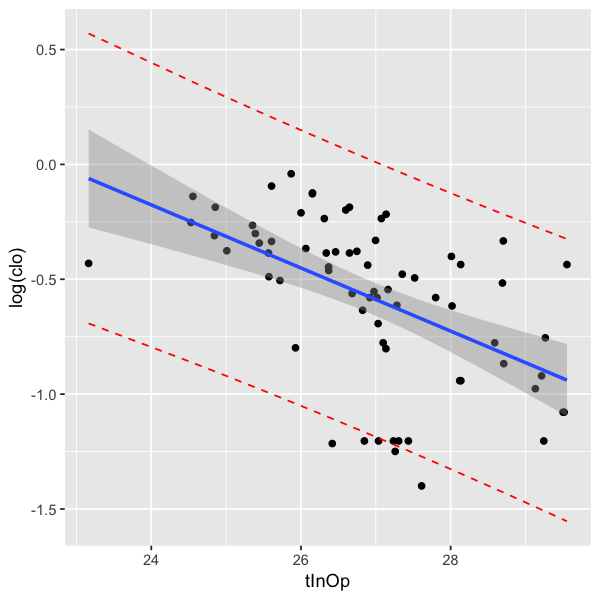

In [53]:
fit_tInOp <- lm(log(clo) ~ tInOp, data = fem)
pred.int <- predict(fit_tInOp, interval = "prediction")
mydata <- cbind(fem, pred.int)
p <- ggplot(mydata, aes(tInOp, log(clo))) + geom_point() + stat_smooth(method = lm)
p + geom_line(aes(y = lwr), color = "red", linetype = "dashed") + geom_line(aes(y = upr), color = "red", linetype = "dashed")

Warning message in predict.lm(fit_tInOp, interval = "prediction"):
“predictions on current data refer to _future_ responses
”

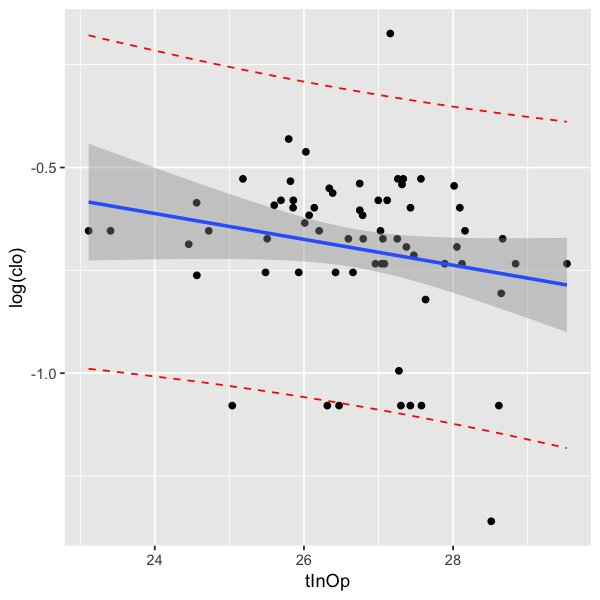

In [54]:
fit_tInOp <- lm(log(clo) ~ tInOp, data = male)
pred.int <- predict(fit_tInOp, interval = "prediction")
mydata <- cbind(male, pred.int)
p <- ggplot(mydata, aes(tInOp, log(clo))) + geom_point() + stat_smooth(method = lm)
p + geom_line(aes(y = lwr), color = "red", linetype = "dashed") + geom_line(aes(y = upr), color = "red", linetype = "dashed")

### Simple linear regression for level of clothing (clo) based on I((tOut - mean(I(tOut)))^2) (I((tOut - mean(I(tOut)))^2))

Warning message in predict.lm(fit_in_out, interval = "prediction"):
“predictions on current data refer to _future_ responses
”

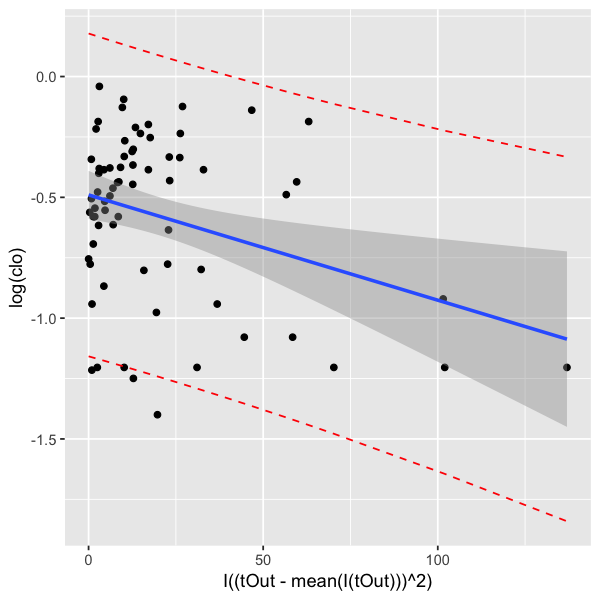

In [55]:
fit_in_out <- lm(log(clo) ~ I((tOut - mean(I(tOut)))^2), data = fem)
pred.int <- predict(fit_in_out, interval = "prediction")
mydata <- cbind(fem, pred.int)
p <- ggplot(mydata, aes(I((tOut - mean(I(tOut)))^2), log(clo))) + geom_point() + stat_smooth(method = lm)
p + geom_line(aes(y = lwr), color = "red", linetype = "dashed") + geom_line(aes(y = upr), color = "red", linetype = "dashed")

Warning message in predict.lm(fit_in_out, interval = "prediction"):
“predictions on current data refer to _future_ responses
”

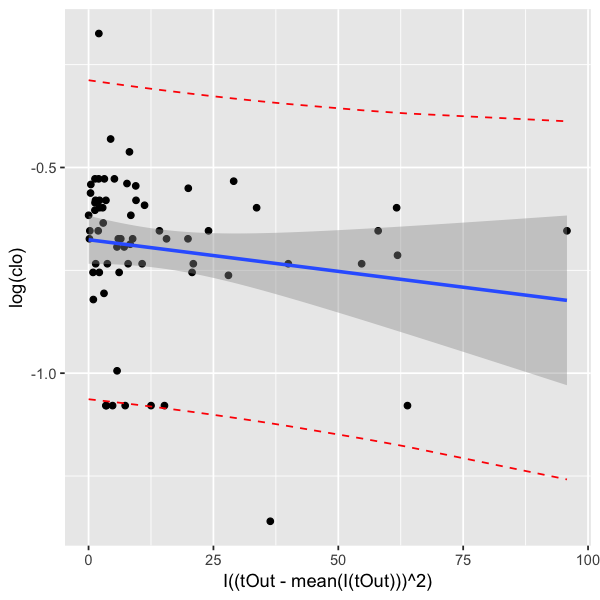

In [56]:
fit_in_out <- lm(log(clo) ~ I((tOut - mean(I(tOut)))^2), data = male)
pred.int <- predict(fit_in_out, interval = "prediction")
mydata <- cbind(male, pred.int)
p <- ggplot(mydata, aes(I((tOut - mean(I(tOut)))^2), log(clo))) + geom_point() + stat_smooth(method = lm)
p + geom_line(aes(y = lwr), color = "red", linetype = "dashed") + geom_line(aes(y = upr), color = "red", linetype = "dashed")

### Weighted analysis for sexes

#### Visualization for the temperature spread across sexes

In [24]:
fem <- subset(HE, (sex == 'female'));
male <- subset(HE, (sex == 'male'));

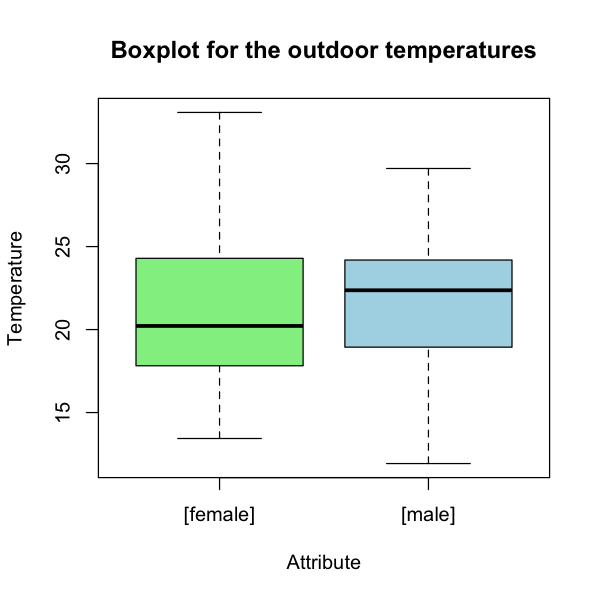

In [25]:
boxplot(fem$tOut, male$tOut,
        names=c("[female]", "[male]"), 
        xlab="Attribute", ylab="Temperature", main="Boxplot for the outdoor temperatures", col=c("lightgreen","Lightblue"))

1. Data points for females are spread out over temperature more than the ones for males.
2. Mean outdoor temperature for females is lower than the one more males.
3. Minimum temperature is recorded for males, while maximum - for females.

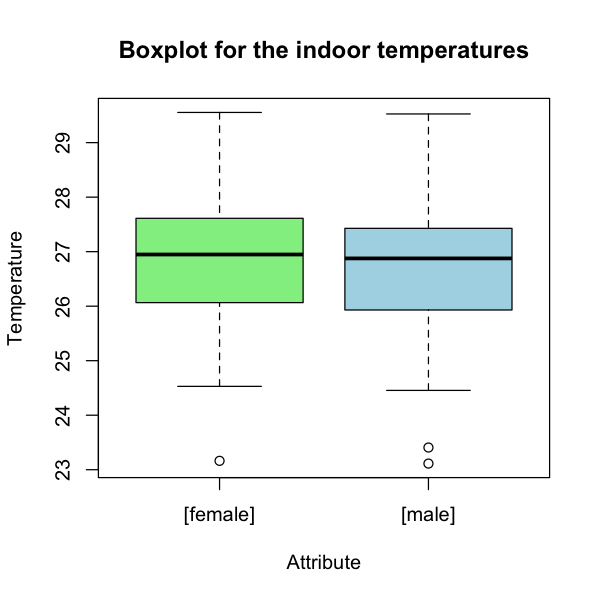

In [26]:
boxplot(fem$tInOp, male$tInOp,
        names=c("[female]", "[male]"), 
        xlab="Attribute", ylab="Temperature", main="Boxplot for the indoor temperatures", col=c("lightgreen","Lightblue"))

1. Indoor temperature is more or less evenly distributed between sexes.
2. Females register one outlier, while males have two outliers (i.e data point out of the 1.5*IQR).
3. The mean of the indoor temperature is slightly bigger than the one for males.

### Histogram for the level of clothing

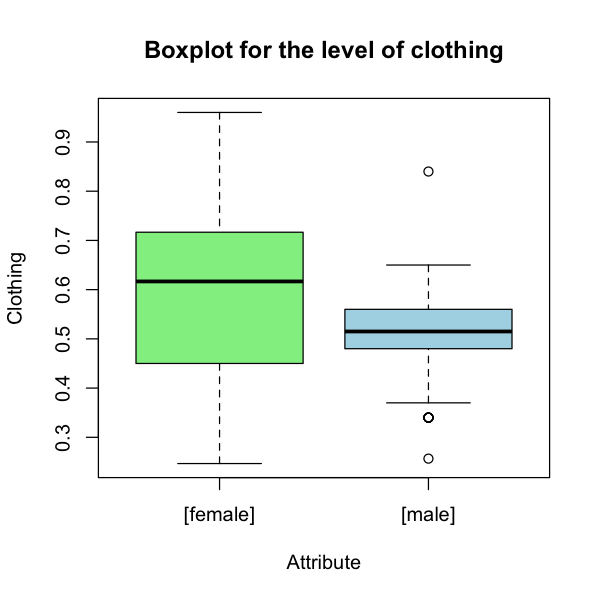

In [27]:
fem <- subset(HE, (sex == 'female'));
male <- subset(HE, (sex == 'male'));

boxplot(fem$clo, male$clo,
        names=c("[female]", "[male]"), 
        xlab="Attribute", ylab="Clothing", main="Boxplot for the level of clothing", col=c("lightgreen","Lightblue"))

1. The level of clothing for females is significantly more spread out than the one for males.
2. The mean level of clothing is higher for females.
3. There are no outliers (i.e out of the 1.5*IQR data points) for females, while we have a few for males.

### Find optimal variance matrix based on the variance of samples within the sex groups

In [60]:
# Sort data by sex
data_f = subset(HE, sex=="female")
data_m = subset(HE, sex=="male")
data = rbind(data_m, data_f)

In [61]:
lm_model1 = lm(log(clo) ~ sex + tOut + tInOp + I((tOut - mean(I(tOut)))^2), data = data)
summary(lm_model1)


Call:
lm(formula = log(clo) ~ sex + tOut + tInOp + I((tOut - mean(I(tOut)))^2), 
    data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.76617 -0.10623  0.03195  0.12574  0.54524 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  1.2073984  0.4402834   2.742  0.00695 ** 
sexmale                     -0.1336548  0.0408447  -3.272  0.00136 ** 
tOut                        -0.0265305  0.0058137  -4.563 1.14e-05 ***
tInOp                       -0.0435295  0.0182391  -2.387  0.01843 *  
I((tOut - mean(I(tOut)))^2) -0.0022795  0.0009107  -2.503  0.01354 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2334 on 131 degrees of freedom
Multiple R-squared:  0.3662,	Adjusted R-squared:  0.3468 
F-statistic: 18.92 on 4 and 131 DF,  p-value: 2.674e-12


#### Create weights for male and female  

#### Check the difference in variance for males and females

In [62]:
variance <- tapply(residuals(lm_model1), HE$sex, var)
variance

female       male 
0.04521016 0.06101076

#### Concept check with the indetity matrix as the weights (i.e should resamble the unweighted lm output)

In [63]:
# Add weights to see how the residuls of the model responds.
wts_m = matrix(1,nrow=dim(data_m[1]))
wts_f = matrix(1,nrow=dim(data_f)[1])
wts = c(wts_m, wts_f)

In [65]:
lm_model = lm(log(clo) ~ sex + tOut + tInOp + I((tOut - mean(I(tOut)))^2), data = data, weights = wts)
summary(lm_model)


Call:
lm(formula = log(clo) ~ sex + tOut + tInOp + I((tOut - mean(I(tOut)))^2), 
    data = data, weights = wts)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.76617 -0.10623  0.03195  0.12574  0.54524 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  1.2073984  0.4402834   2.742  0.00695 ** 
sexmale                     -0.1336548  0.0408447  -3.272  0.00136 ** 
tOut                        -0.0265305  0.0058137  -4.563 1.14e-05 ***
tInOp                       -0.0435295  0.0182391  -2.387  0.01843 *  
I((tOut - mean(I(tOut)))^2) -0.0022795  0.0009107  -2.503  0.01354 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2334 on 131 degrees of freedom
Multiple R-squared:  0.3662,	Adjusted R-squared:  0.3468 
F-statistic: 18.92 on 4 and 131 DF,  p-value: 2.674e-12


#### Remark:

Setting up the weights for both sexes - male and female equal to 1, we reach the usual lm output (i.e having the itentity matrix as the covariance matrix).

#### Fine-tunning the weights for females (i.e seen in relation to the one for males)

Find optimal weight that maximizes the log likelihood of the model. We do this by simply runing a for loop through various weights and plotting the outputs to find which weight gives the maximum.

 #### Different weights to be tested

In [66]:
wts_ = seq(0.1,1,0.01)

In [67]:
llh = c()
for(i in wts_){
  wts_m = matrix(1,ncol=dim(data_m[1]))
  wts_f = matrix(i,ncol=dim(data_f)[1]) # Put the weights on female
  wts = c(wts_m, wts_f)
  glm_model = glm(log(clo) ~ sex + tOut + tInOp + I((tOut - mean(I(tOut)))^2), data=data, weights=wts)
  llh_ = logLik(glm_model)
  llh = c(llh, llh_)
}

[1] 14.45442

[1] 29

[1] 0.38

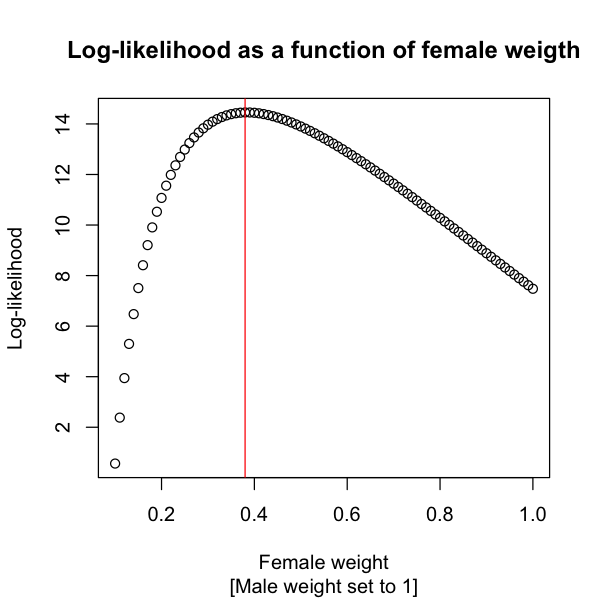

In [68]:
max(llh)
which.max(llh)
wts_[which.max(llh)]
plot(wts_, llh, xlab = "Female weight", ylab = "Log-likelihood", main = "Log-likelihood as a function of female weigth", sub = "[Male weight set to 1]")
abline(v = wts_[which.max(llh)], col="red")

In [69]:
wts_m = matrix(1,nrow=dim(data_m[1]))
wts_f = matrix(wts_[which.max(llh)],nrow=dim(data_f)[1])
wts = c(wts_m, wts_f)


Call:
lm(formula = log(clo) ~ sex + tOut + tInOp + I((tOut - mean(I(tOut)))^2), 
    data = data, weights = wts)

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-0.46944 -0.08316  0.03095  0.10639  0.47182 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  0.9350080  0.3901737   2.396  0.01797 *  
sexmale                     -0.1347382  0.0403264  -3.341  0.00109 ** 
tOut                        -0.0239193  0.0050350  -4.751 5.25e-06 ***
tInOp                       -0.0352480  0.0156467  -2.253  0.02594 *  
I((tOut - mean(I(tOut)))^2) -0.0025968  0.0008604  -3.018  0.00306 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1728 on 131 degrees of freedom
Multiple R-squared:  0.3323,	Adjusted R-squared:  0.3119 
F-statistic:  16.3 on 4 and 131 DF,  p-value: 7.347e-11


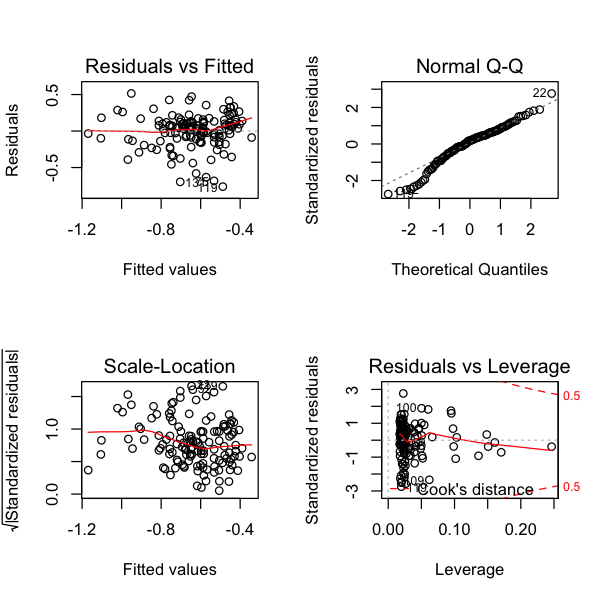

In [73]:
glm_model2 = lm(log(clo) ~ sex + tOut + tInOp + I((tOut - mean(I(tOut)))^2), data = data, weights = wts)
summary(glm_model2)

par(mfrow=c(2,2))
plot(glm_model2)

### Visualization of the model with confidence and prediction intervals

### 1. clo ~ tOut

#### Weighting based on sexes

Warning message:
“In lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...) :
 extra argument ‘weigths’ will be disregarded”Warning message in predict.lm(fit_tOut1, interval = "prediction"):
“predictions on current data refer to _future_ responses
”

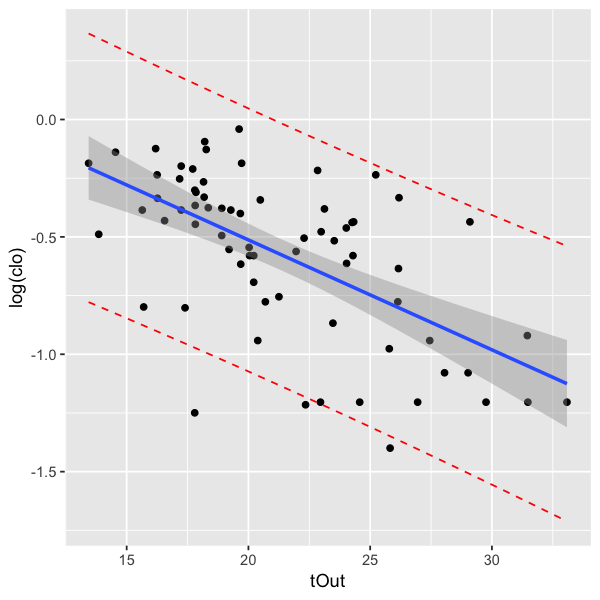

In [80]:
fit_tOut1 <- lm(log(clo) ~ tOut, data = fem, weigths = wts)
pred_tOut1 <- predict(fit_tOut1, interval = "prediction")
mydata_tOut1 <- cbind(fem, pred_tOut1)
p_tOut1 <- ggplot(mydata_tOut1, aes(tOut, log(clo))) + geom_point() + stat_smooth(method = lm)
p_tOut1 + geom_line(aes(y = lwr), color = "red", linetype = "dashed") + geom_line(aes(y = upr), color = "red", linetype = "dashed")

Warning message:
“In lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...) :
 extra argument ‘weigths’ will be disregarded”Warning message in predict.lm(fit_tOut1, interval = "prediction"):
“predictions on current data refer to _future_ responses
”

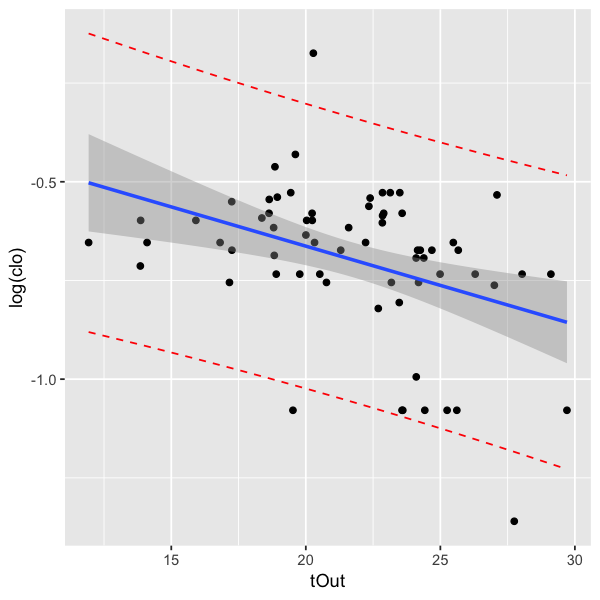

In [81]:
fit_tOut1 <- lm(log(clo) ~ tOut, data = male, weigths = wts)
pred_tOut1 <- predict(fit_tOut1, interval = "prediction")
mydata_tOut1 <- cbind(male, pred_tOut1)
p_tOut1 <- ggplot(mydata_tOut1, aes(tOut, log(clo))) + geom_point() + stat_smooth(method = lm)
p_tOut1 + geom_line(aes(y = lwr), color = "red", linetype = "dashed") + geom_line(aes(y = upr), color = "red", linetype = "dashed")

### 2. clo ~ tInOp

#### Males and females

Warning message:
“In lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...) :
 extra argument ‘weigths’ will be disregarded”Warning message in predict.lm(fit_tInOp1, interval = "prediction"):
“predictions on current data refer to _future_ responses
”

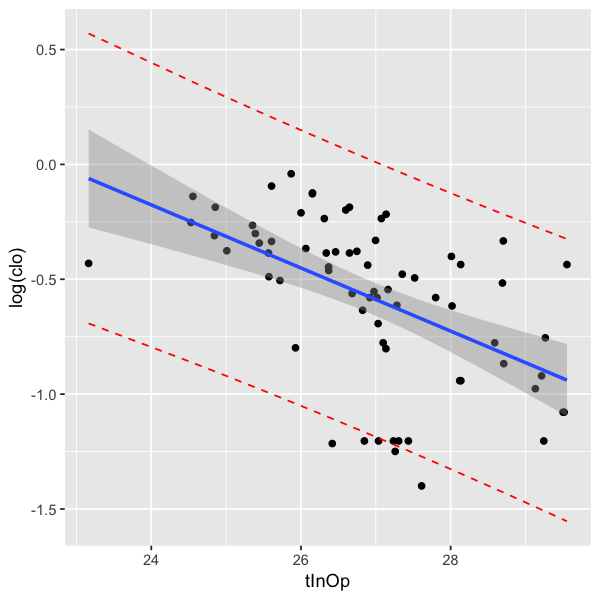

In [82]:
fit_tInOp1 <- lm(log(clo) ~ tInOp, data = fem, weigths = wts)
pred_tInOp1 <- predict(fit_tInOp1, interval = "prediction")
mydata_tOut1 <- cbind(fem, pred_tInOp1)
p_tInOp1 <- ggplot(mydata_tOut1, aes(tInOp, log(clo))) + geom_point() + stat_smooth(method = lm)
p_tInOp1 + geom_line(aes(y = lwr), color = "red", linetype = "dashed") + geom_line(aes(y = upr), color = "red", linetype = "dashed")

Warning message:
“In lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...) :
 extra argument ‘weigths’ will be disregarded”Warning message in predict.lm(fit_tInOp1, interval = "prediction"):
“predictions on current data refer to _future_ responses
”

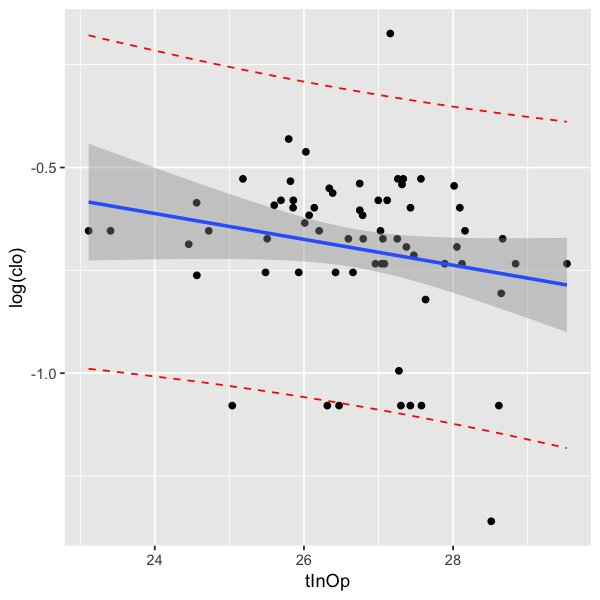

In [83]:
fit_tInOp1 <- lm(log(clo) ~ tInOp, data = male, weigths = wts)
pred_tInOp1 <- predict(fit_tInOp1, interval = "prediction")
mydata_tOut1 <- cbind(male, pred_tInOp1)
p_tInOp1 <- ggplot(mydata_tOut1, aes(tInOp, log(clo))) + geom_point() + stat_smooth(method = lm)
p_tInOp1 + geom_line(aes(y = lwr), color = "red", linetype = "dashed") + geom_line(aes(y = upr), color = "red", linetype = "dashed")

Warning message:
“In lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...) :
 extra argument ‘weigths’ will be disregarded”Warning message in predict.lm(fit_tInOp1, interval = "prediction"):
“predictions on current data refer to _future_ responses
”

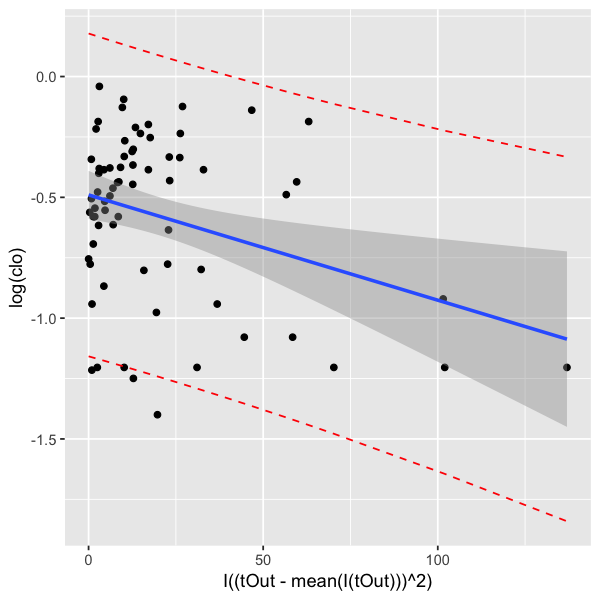

In [85]:
fit_tInOp1 <- lm(log(clo) ~ I((tOut - mean(I(tOut)))^2), data = fem, weigths = wts)
pred_tInOp1 <- predict(fit_tInOp1, interval = "prediction")
mydata_tOut1 <- cbind(fem, pred_tInOp1)
p_tInOp1 <- ggplot(mydata_tOut1, aes(I((tOut - mean(I(tOut)))^2), log(clo))) + geom_point() + stat_smooth(method = lm)
p_tInOp1 + geom_line(aes(y = lwr), color = "red", linetype = "dashed") + geom_line(aes(y = upr), color = "red", linetype = "dashed")

Warning message:
“In lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...) :
 extra argument ‘weigths’ will be disregarded”Warning message in predict.lm(fit_tInOp1, interval = "prediction"):
“predictions on current data refer to _future_ responses
”

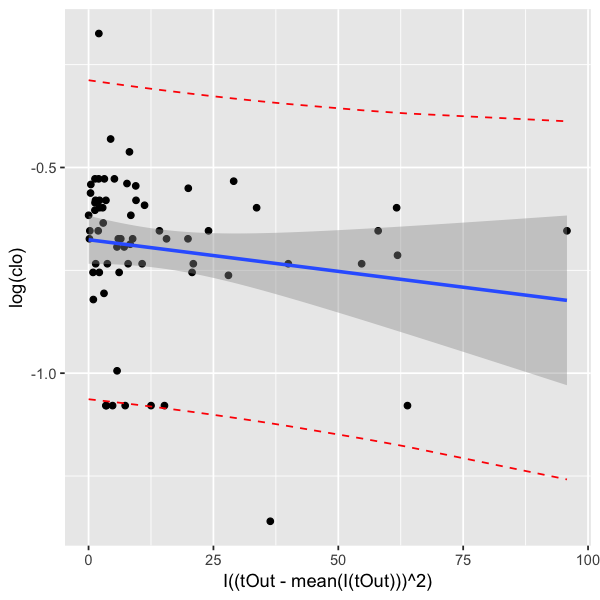

In [86]:
fit_tInOp1 <- lm(log(clo) ~ I((tOut - mean(I(tOut)))^2), data = male, weigths = wts)
pred_tInOp1 <- predict(fit_tInOp1, interval = "prediction")
mydata_tOut1 <- cbind(male, pred_tInOp1)
p_tInOp1 <- ggplot(mydata_tOut1, aes(I((tOut - mean(I(tOut)))^2), log(clo))) + geom_point() + stat_smooth(method = lm)
p_tInOp1 + geom_line(aes(y = lwr), color = "red", linetype = "dashed") + geom_line(aes(y = upr), color = "red", linetype = "dashed")

### Check based on residuals if subjectId can be ignored

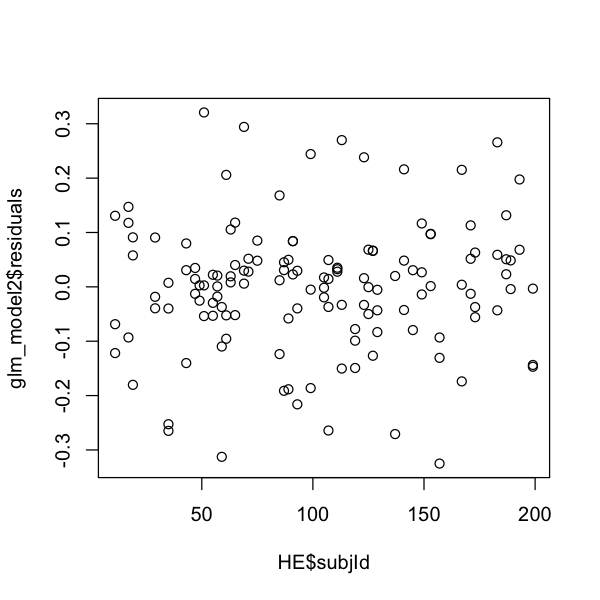

In [76]:
plot(HE$subjId, glm_model2$residuals)

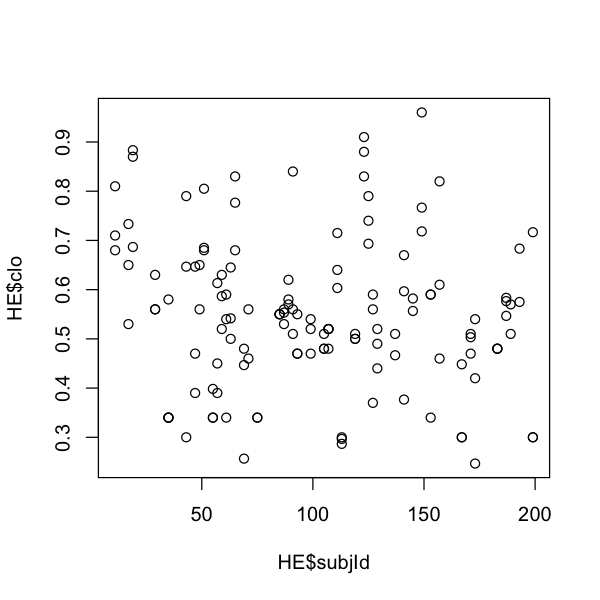

In [77]:
plot(HE$subjId,HE$clo)

By plotting the residuals based on the subject ID, we may see that there is a high variation between subject IDs. Further on, the level of clothing varies a lot based on the subject ID. Thus, it is important to include it as well in the model.

### Problem 2: Including subject Id

On each subject ID the outdoor temperature and level of clothing play a significant role (e.g even though subject ID 11 or 51 is defined by having a high level of clothing, that number is proportional to the outdoor temperature than is 19.15 C; on the other hand, due to the high outdoor temperature, the subject ID 55 has a low level of clothing).

In [91]:
cbind(with(HE, aggregate(tOut ~ subjId, FUN = "mean")),with(HE, aggregate(clo ~ subjId, FUN = "mean"))[2])

subjId,tOut,clo
11,19.15951,0.7333333
17,20.18804,0.6377778
19,16.36067,0.8133333
29,22.84365,0.5833333
35,21.74722,0.4000000
43,28.60078,0.5788889
47,24.34119,0.5022222
49,19.12215,0.6050000
51,19.66243,0.7233333
55,29.50992,0.3594444


### Add subjectID in the model or use model comparison

In [139]:
initial_model_problem_B = lmer(log(clo) ~ sex * tOut * tInOp * (1 | subjId) * I((tOut - mean(I(tOut)))^2) * I((tInOp - mean(I(tInOp)))^2), REML = FALSE, data = data)

Warning message:
“Some predictor variables are on very different scales: consider rescaling”Warning message:
“Some predictor variables are on very different scales: consider rescaling”

In [141]:
final_model_problem_A <- lmer(log(clo) ~ sex + tOut + tInOp + I((tOut - mean(I(tOut)))^2) + (1 | subjId), REML = FALSE, data = data)
anova(initial_model_problem_B, final_model_problem_A)
summary(final_model_problem_A)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
final_model_problem_A,7,-23.88897,-3.500389,18.94449,-37.88897,NA,NA,NA
initial_model_problem_B,34,5.68238,104.712646,31.15881,-62.31762,24.42865,27,0.6064478


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: log(clo) ~ sex + tOut + tInOp + I((tOut - mean(I(tOut)))^2) +  
    (1 | subjId)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   -23.9     -3.5     18.9    -37.9      129 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5992 -0.5287 -0.0063  0.5931  3.2643 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjId   (Intercept) 0.02332  0.1527  
 Residual             0.02940  0.1715  
Number of obs: 136, groups:  subjId, 47

Fixed effects:
                              Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                  6.798e-01  4.564e-01  1.307e+02   1.489  0.13877
sexmale                     -1.252e-01  5.424e-02  4.704e+01  -2.309  0.02540
tOut                        -2.870e-02  5.364e-03  1.311e+02  -5.350  3.8e-07
tInOp                       -2.216e-02  1.829e-02  1.346e+02  -1.212  0.22773
I((tOut - mean(I

In [143]:
rs_subj_sex_ml = lmer(log(clo) ~ 1 + tOut + tInOp + I((tOut - mean(I(tOut)))^2) + (1 | subjId), REML = FALSE, data = data)
anova(model001, rs_subj_sex_ml)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
rs_subj_sex_ml,6,-20.88986,-3.413928,16.44493,-32.88986,NA,NA,NA
model001,7,-23.88897,-3.500389,18.94449,-37.88897,4.999116,1,0.02536027


In [144]:
rs_subj_tOut_ml = lmer(log(clo) ~ sex + 1 + tInOp + I((tOut - mean(I(tOut)))^2) + (1 | subjId), REML = FALSE, data = data)
anova(model001, rs_subj_tOut_ml)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
rs_subj_tOut_ml,6,-0.180973,17.294956,6.090486,-12.18097,NA,NA,NA
model001,7,-23.888973,-3.500389,18.944487,-37.88897,25.708,1,3.971771e-07


In [167]:
rs_subj_tInOp_ml = lmer(log(clo) ~ sex + tOut + I((tOut - mean(I(tOut)))^2) + (1 | subjId), REML = FALSE, data = data)
anova(model001, rs_subj_tInOp_ml)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
rs_subj_tInOp_ml,6,-24.51478,-7.038855,18.25739,-36.51478,NA,NA,NA
model001,7,-23.88897,-3.500389,18.94449,-37.88897,1.374189,1,0.2410935


In [146]:
rs_subj_tInOp_norm_ml = lmer(log(clo) ~ sex + tOut + tInOp + 1 + (1 | subjId), REML = FALSE, data = data)
anova(model001, rs_subj_tInOp_norm_ml)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
rs_subj_tInOp_norm_ml,6,-18.47468,-0.9987539,15.23734,-30.47468,NA,NA,NA
model001,7,-23.88897,-3.5003892,18.94449,-37.88897,7.41429,1,0.006470784


In [147]:
rs_subj_sex_tInOp_ml = lmer(log(clo) ~ 1 + tOut + 1 + I((tOut - mean(I(tOut)))^2) + (1 | subjId), REML = FALSE, data = data)
anova(model001, rs_subj_sex_tInOp_ml)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
rs_subj_sex_tInOp_ml,5,-22.21098,-7.647706,16.10549,-32.21098,NA,NA,NA
model001,7,-23.88897,-3.500389,18.94449,-37.88897,5.677993,2,0.05848432


In [148]:
rs_subj_sex_tInOp_tOut_ml = lmer(log(clo) ~ 1 + 1 + 1 + I((tOut - mean(I(tOut)))^2) + (1 | subjId), REML = FALSE, data = data)
anova(model001, rs_subj_sex_tInOp_tOut_ml)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
rs_subj_sex_tInOp_tOut_ml,4,12.70079,24.351411,-2.350396,4.700792,NA,NA,NA
model001,7,-23.88897,-3.500389,18.944487,-37.888973,42.58976,3,3.007481e-09


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: log(clo) ~ sex + tOut + I((tOut - mean(I(tOut)))^2) + (1 | subjId)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   -24.5     -7.0     18.3    -36.5      130 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5053 -0.4064 -0.0167  0.5336  3.1715 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjId   (Intercept) 0.02551  0.1597  
 Residual             0.02895  0.1702  
Number of obs: 136, groups:  subjId, 47

Fixed effects:
                              Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                  1.398e-01  1.089e-01  1.341e+02   1.284  0.20123
sexmale                     -1.177e-01  5.547e-02  4.813e+01  -2.122  0.03898
tOut                        -3.146e-02  4.821e-03  1.351e+02  -6.526 1.25e-09
I((tOut - mean(I(tOut)))^2) -2.223e-03  8.421e-04  1.292e+02  -2.640  0.00931
                              

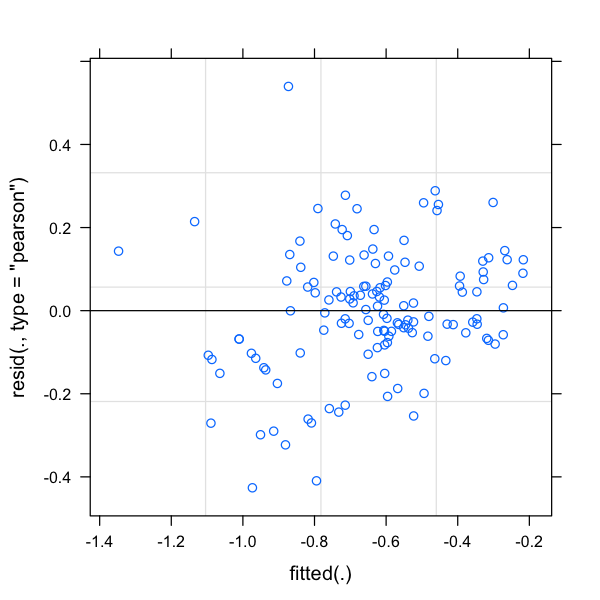

In [172]:
summary(rs_subj_tInOp_ml)
par(mfrow=c(2,2))
plot(rs_subj_tInOp_ml)

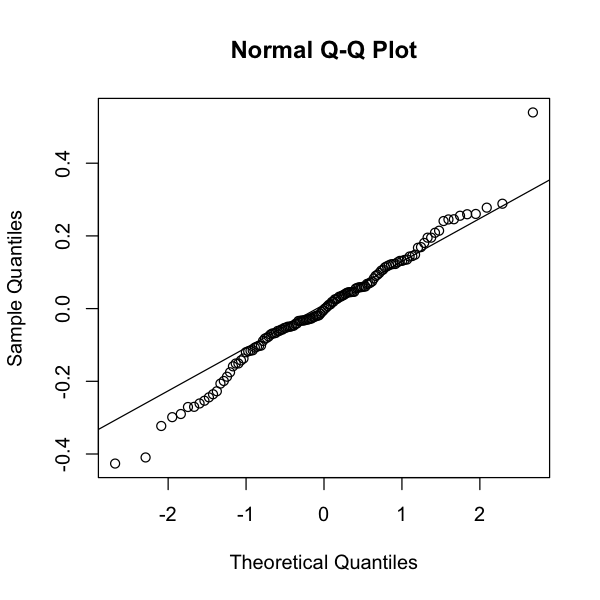

In [192]:
qqnorm(resid(rs_subj_tInOp_ml))
qqline(resid(rs_subj_tInOp_ml))

In [194]:
install.packages("ggeffects")

also installing the dependencies ‘insight’, ‘sjlabelled’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


Model contains polynomial or cubic / quadratic terms. Consider using `terms="tOut [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.
Model has log-transformed response. Back-transforming predictions to original response scale. Standard errors are still on the log-scale.


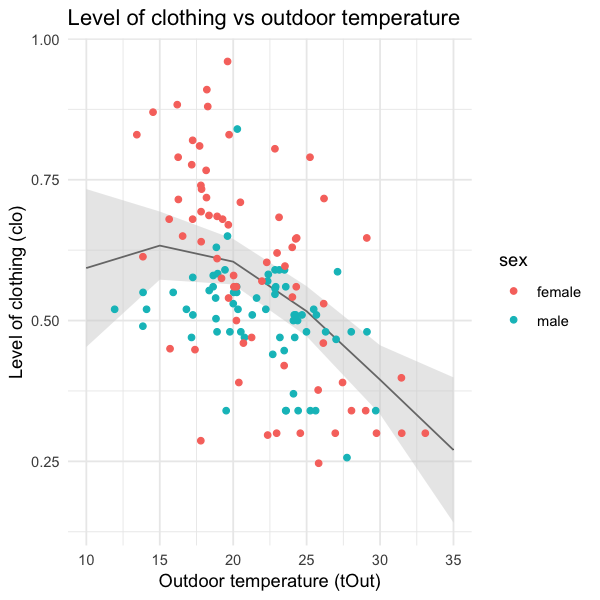

In [198]:
library(ggeffects)  # install the package first if you haven't already, then load it

# Extract the prediction data frame
pred.mm <- ggpredict(rs_subj_tInOp_ml, terms = c("tOut"))  # this gives overall predictions for the model

# Plot the predictions 

(ggplot(pred.mm) + 
   geom_line(aes(x = x, y = predicted)) +          # slope
   geom_ribbon(aes(x = x, ymin = predicted - std.error, ymax = predicted + std.error), 
               fill = "lightgrey", alpha = 0.5) +  # error band
   geom_point(data = data,                      # adding the raw data (scaled values)
              aes(x = tOut, y = clo, colour = sex)) + 
   labs(x = "Outdoor temperature (tOut)", y = "Level of clothing (clo)", 
        title = "Level of clothing vs outdoor temperature") + 
   theme_minimal()
)

In [182]:
options(repr.plot.width=10, repr.plot.height=10)

Warning message in qt((1 - level)/2, df):
“NaNs produced”Warning message in qt((1 - level)/2, df):
“NaNs produced”

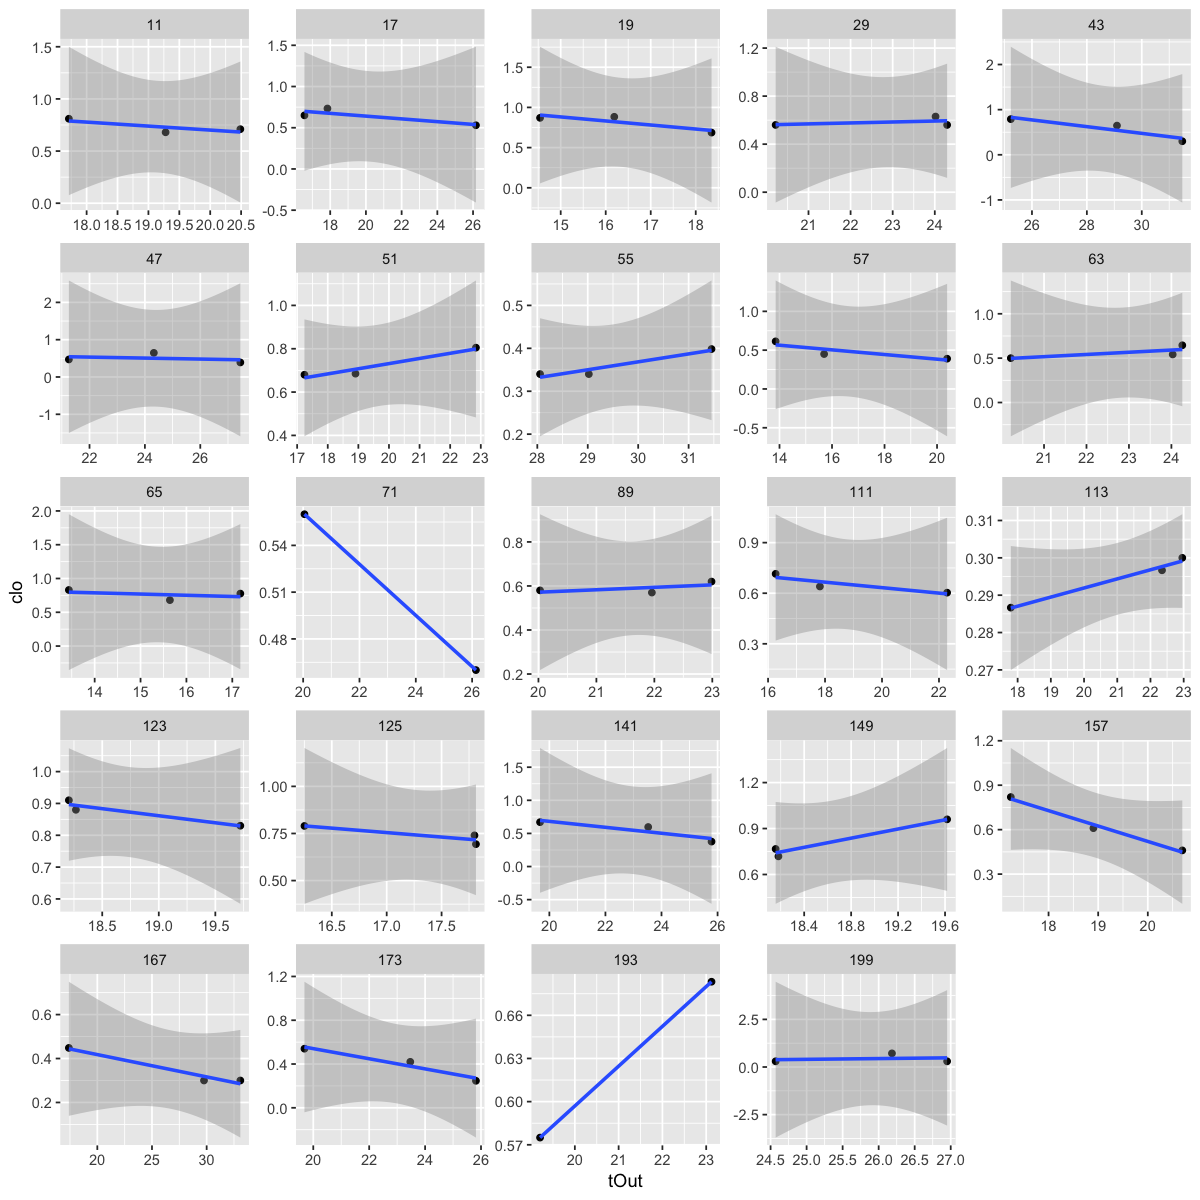

In [189]:
(ggplot(fem, aes(x=tOut, y=clo))
     #tell ggplot what data is, and x and y variables
     +facet_wrap(~subjId, ncol=5, scales='free')
     #add a wrapping by unique combos of 2 variable
     #set num columns, and vary scales per facet.
     +geom_point()
     #add the points as representations
     +stat_smooth(method='lm', aes(group=1))
     #add the linear fits.
)

In [12]:
options(repr.plot.width=5, repr.plot.height=5)

### Problem C: The full data-set

In [15]:
setwd("~/Desktop/DTU/Advanced\ Dataanalysis\ and\ Statistical\ Modelling/Assignments")
HE_full <- read.table("clothingFull.csv", sep=",", header=TRUE, as.is=TRUE)

In [16]:
summary(HE_full)
head(HE_full)

       X              clo              tOut            tInOp      
 Min.   :  1.0   Min.   :0.2300   Min.   : 9.337   Min.   :22.29  
 1st Qu.:201.5   1st Qu.:0.4700   1st Qu.:18.067   1st Qu.:25.47  
 Median :402.0   Median :0.5400   Median :21.226   Median :26.85  
 Mean   :402.0   Mean   :0.5515   Mean   :21.548   Mean   :26.83  
 3rd Qu.:602.5   3rd Qu.:0.6400   3rd Qu.:24.790   3rd Qu.:28.04  
 Max.   :803.0   Max.   :0.9700   Max.   :36.234   Max.   :32.20  
     sex                subjId           day            obs.no     
 Length:803         Min.   : 11.0   Min.   :1.000   Min.   :1.000  
 Class :character   1st Qu.: 59.0   1st Qu.:1.000   1st Qu.:2.000  
 Mode  :character   Median : 99.0   Median :2.000   Median :3.000  
                    Mean   :101.2   Mean   :1.971   Mean   :3.471  
                    3rd Qu.:141.0   3rd Qu.:3.000   3rd Qu.:5.000  
                    Max.   :199.0   Max.   :4.000   Max.   :6.000  

X,clo,tOut,tInOp,sex,subjId,day,obs.no
1,0.71,17.26720,22.28525,female,11,1,1
2,0.71,20.70000,24.57230,female,11,1,2
3,0.71,20.54773,25.55077,female,11,1,3
4,0.71,21.90000,26.40069,female,11,1,4
5,0.71,21.52080,26.66522,female,11,1,5
6,0.71,20.99017,27.18361,female,11,1,6


#### Add parameters to mixed linear model in increaments to find which ones give significance to the fit. We will keep subjId and day as random intercets since this does not seem to be an independent parameter.

In [47]:
initial_model_problem_C = lmer(log(clo) ~ sex * tOut * tInOp * I((tOut - mean(I(tOut)))^2) * I((tInOp - mean(I(tInOp)))^2) * (1 | subjId) * (1 | day) + (1 | obs.no), REML = FALSE, data = HE_full)
summary(initial_model_problem_C)

Warning message:
"Some predictor variables are on very different scales: consider rescaling"Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Correlation matrix not shown by default, as p = 32 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: log(clo) ~ sex * tOut * tInOp * I((tOut - mean(I(tOut)))^2) *  
    I((tInOp - mean(I(tInOp)))^2) * (1 | subjId) * (1 | day) +  
    (1 | obs.no)
   Data: HE_full

     AIC      BIC   logLik deviance df.resid 
  -432.9   -264.1    252.5   -504.9      767 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7546 -0.4817 -0.0299  0.4407  3.4670 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjId   (Intercept) 0.035919 0.18952 
 obs.no   (Intercept) 0.001125 0.03354 
 day      (Intercept) 0.021737 0.14743 
 Residual             0.025062 0.15831 
Number of obs: 803, groups:  subjId, 47; obs.no, 6; day, 4

Fixed effects:
                                                                               Estimate
(Intercept)                                                                   7.657e+00
sexmale                                                        

In [63]:
final_model_problem_B <- lmer(log(clo) ~ sex + tOut + 1 + I((tOut - mean(I(tOut)))^2) + (1 | subjId) + (1 | day) + (1 | obs.no), REML = FALSE, data = HE_full)
anova(initial_model_problem_C, final_model_problem_B)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00324929 (tol = 0.002, component 1)"

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
final_model_problem_B,9,-431.9471,-389.7519,224.9736,-449.9471,NA,NA,NA
initial_model_problem_C,36,-432.9047,-264.1240,252.4524,-504.9047,54.9576,27,0.001159847


In [48]:
model_problem_C2 = lmer(log(clo) ~ sex + tOut + tInOp + I((tOut - mean(I(tOut)))^2) + I((tInOp - mean(I(tInOp)))^2) + (1 | subjId) + (1 | day) + (1 | obs.no), REML = FALSE, data = HE_full)
anova(initial_model_problem_C, model_problem_C2)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00610248 (tol = 0.002, component 1)"

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
model_problem_C2,10,-428.0684,-381.1849,224.0342,-448.0684,NA,NA,NA
initial_model_problem_C,36,-432.9047,-264.1240,252.4524,-504.9047,56.83629,26,0.000439749


In [49]:
model_problem_C3 = lmer(log(clo) ~ sex + tOut+ I((tOut - mean(I(tOut)))^2) + I((tInOp - mean(I(tInOp)))^2) + (1 | subjId) + (1 | day) + (1 | obs.no), REML = FALSE, data = HE_full)
anova(initial_model_problem_C, model_problem_C3)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00416899 (tol = 0.002, component 1)"

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
model_problem_C3,9,-429.8893,-387.6941,223.9447,-447.8893,NA,NA,NA
initial_model_problem_C,36,-432.9047,-264.1240,252.4524,-504.9047,57.01539,27,0.0006402889


In [50]:
model_problem_C4 = lmer(log(clo) ~ sex + tOut + I((tOut - mean(I(tOut)))^2) + (1 | subjId) + (1 | day) + (1 | obs.no), REML = FALSE, data = HE_full)
anova(initial_model_problem_C, model_problem_C4)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
model_problem_C4,8,-431.8510,-394.3442,223.9255,-447.8510,NA,NA,NA
initial_model_problem_C,36,-432.9047,-264.1240,252.4524,-504.9047,57.05373,28,0.000955175


In [52]:
model_problem_C5 = lmer(log(clo) ~ sex + tOut + I((tOut - mean(I(tOut)))^2) + (1 | subjId) + (1 | day/obs.no), REML = FALSE, data = HE_full)
anova(initial_model_problem_C, model_problem_C5)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
model_problem_C5,8,-425.3225,-387.8157,220.6613,-441.3225,NA,NA,NA
initial_model_problem_C,36,-432.9047,-264.1240,252.4524,-504.9047,63.5822,28,0.0001392424


In [61]:
model_problem_C6 = lmer(log(clo) ~ sex + tOut + (1 | subjId) + (1 | day) + (1 | obs.no), REML = FALSE, data = HE_full)
anova(model_problem_C5, model_problem_C6)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
model_problem_C6,7,-423.3019,-390.4834,218.6510,-437.3019,NA,NA,NA
model_problem_C5,8,-425.3225,-387.8157,220.6613,-441.3225,4.020606,1,0.04494756


In [69]:
model_problem_C7 = lmer(log(clo) ~ sex + tOut + (1 | subjId) + (1 | day/obs.no), REML = FALSE, data = HE_full)
anova(model_problem_C6, model_problem_C7)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00288105 (tol = 0.002, component 1)"

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
model_problem_C6,7,-423.3019,-390.4834,218.6510,-437.3019,NA,NA,NA
model_problem_C7,7,-415.4256,-382.6071,214.7128,-429.4256,0,0,1


In [70]:
summary(model_problem_C6)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: log(clo) ~ sex + tOut + (1 | subjId) + (1 | day) + (1 | obs.no)
   Data: HE_full

     AIC      BIC   logLik deviance df.resid 
  -423.3   -390.5    218.7   -437.3      796 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5391 -0.4812 -0.0273  0.4974  3.5409 

Random effects:
 Groups   Name        Variance  Std.Dev.
 subjId   (Intercept) 0.0383670 0.19588 
 obs.no   (Intercept) 0.0008306 0.02882 
 day      (Intercept) 0.0183384 0.13542 
 Residual             0.0273853 0.16549 
Number of obs: 803, groups:  subjId, 47; obs.no, 6; day, 4

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  -0.009309   0.092575   9.672723  -0.101    0.922    
sexmale      -0.106762   0.058389  45.984571  -1.828    0.074 .  
tOut         -0.023508   0.002054 470.603369 -11.444   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05

### Model validation

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: log(clo) ~ sex + tOut + 1 + I((tOut - mean(I(tOut)))^2) + (1 |  
    subjId) + (1 | day) + (1 | obs.no)
   Data: HE_full

     AIC      BIC   logLik deviance df.resid 
  -431.9   -394.3    223.9   -447.9      795 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8179 -0.4729 -0.0410  0.4809  3.6629 

Random effects:
 Groups   Name        Variance  Std.Dev.
 subjId   (Intercept) 0.0379405 0.19478 
 obs.no   (Intercept) 0.0007052 0.02656 
 day      (Intercept) 0.0169738 0.13028 
 Residual             0.0270547 0.16448 
Number of obs: 803, groups:  subjId, 47; obs.no, 6; day, 4

Fixed effects:
                              Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                 -2.653e-02  9.034e-02  9.960e+00  -0.294  0.77505
sexmale                     -1.126e-01  5.809e-02  4.608e+01  -1.938  0.05873
tOut                        -2.190e-02  2.

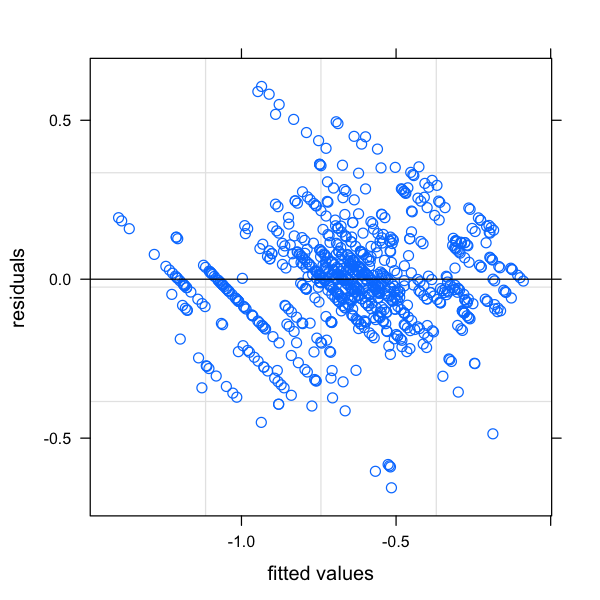

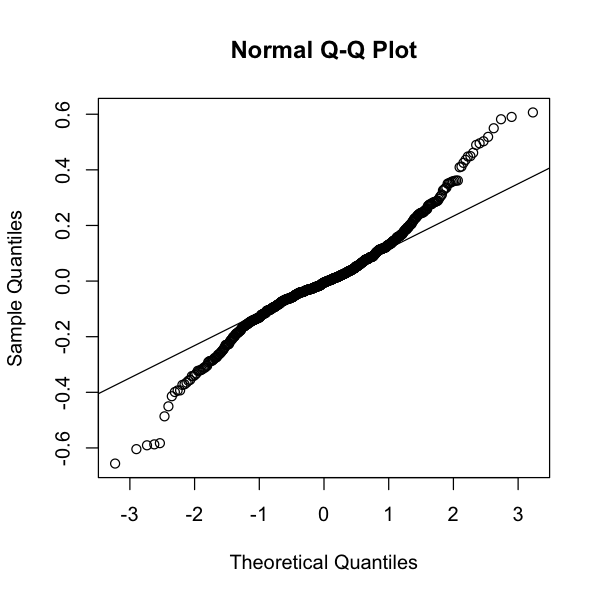

In [26]:
plot(final_model2_problem_C, xlab="fitted values", ylab="residuals")
summary(final_model_problem_B)

qqnorm(resid(final_model2_problem_C))
qqline(resid(final_model2_problem_C))

Model contains polynomial or cubic / quadratic terms. Consider using `terms="tOut [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.
Model has log-transformed response. Back-transforming predictions to original response scale. Standard errors are still on the log-scale.


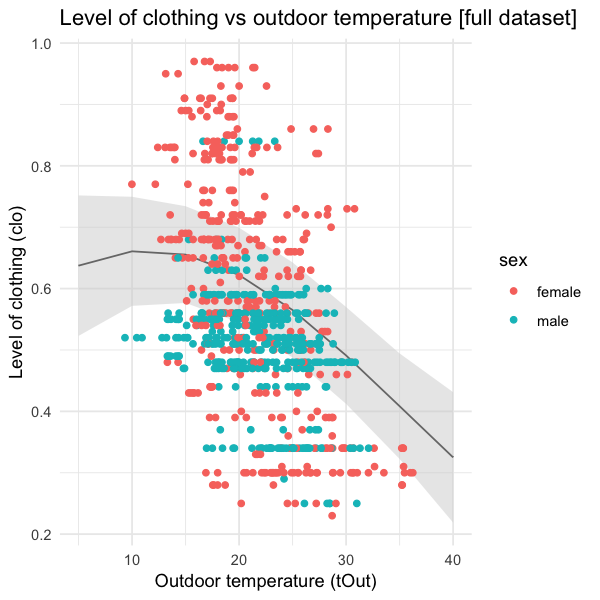

In [27]:
#install.packages("ggeffects")
library(ggeffects)  # install the package first if you haven't already, then load it

# Extract the prediction data frame
pred.mm <- ggpredict(final_model2_problem_C, terms = c("tOut"))  # this gives overall predictions for the model

# Plot the predictions 

(ggplot(pred.mm) + 
   geom_line(aes(x = x, y = predicted)) +          # slope
   geom_ribbon(aes(x = x, ymin = predicted - std.error, ymax = predicted + std.error), 
               fill = "lightgrey", alpha = 0.5) +  # error band
   geom_point(data = HE_full,                      # adding the raw data (scaled values)
              aes(x = tOut, y = clo, colour = sex)) + 
   labs(x = "Outdoor temperature (tOut)", y = "Level of clothing (clo)", 
        title = "Level of clothing vs outdoor temperature [full dataset]") + 
   theme_minimal()
)